# **INTRODUCCION**

En esta sección se evalúa el rendimiento computacional de dos redes neuronales profundas aplicadas al procesamiento de video: un modelo YOLO para detección y segmentación de personas y un modelo de super resolución basado en Deep Learning. El análisis se centra en la comparación entre ejecución en CPU y GPU, manteniendo constante el pipeline de procesamiento con el fin de analizar el impacto del backend de cómputo en términos de FPS y uso de recursos.

# **Detección con YOLOv11**

## **CPU y GPU**

MAC Address del Equipo: 08:92:04:e5:98:36
CUDA Disponible: True

--- INICIANDO PRUEBA YOLOv11 EN CUDA ---

RESULTADOS YOLOv11 (CUDA)
FPS Promedio: 138.79
Uso de RAM del sistema: 27.5%


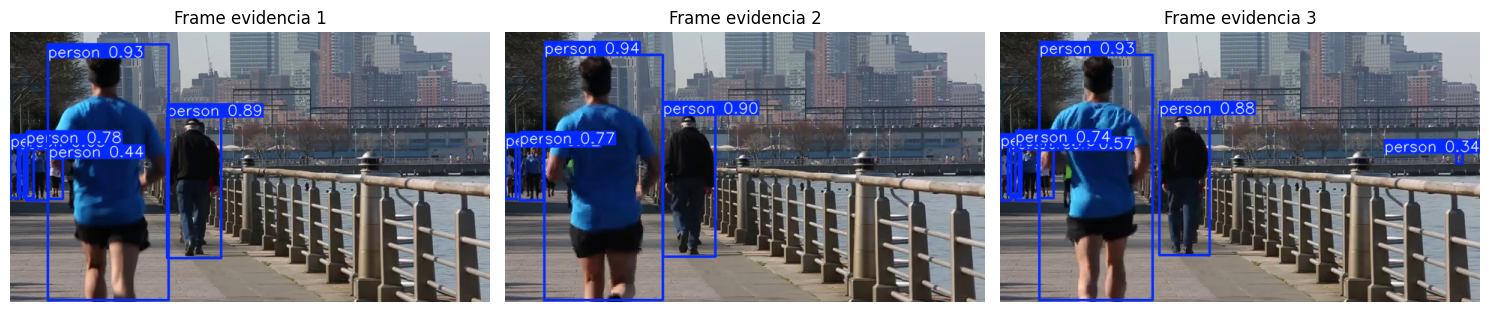

In [15]:
import torch
import cv2
import psutil
import uuid
import time
import matplotlib.pyplot as plt
from ultralytics import YOLO

# ===============================
# 1. IDENTIFICACIÓN DEL EQUIPO
# ===============================
mac_address = ':'.join(
    ['{:02x}'.format((uuid.getnode() >> ele) & 0xff) for ele in range(0, 8*6, 8)][::-1]
)

print("==========================================")
print(f"MAC Address del Equipo: {mac_address}")
print(f"CUDA Disponible: {torch.cuda.is_available()}")
print("==========================================\n")

# ===============================
# 2. ELECCIÓN DE FUENTE
# ===============================
choice = input("Seleccione fuente:\n1 - Video\n2 - Cámara\nOpción: ")

if choice == "1":
    video_path = "video.mp4"  # Video fijo
elif choice == "2":
    video_path = 0  # Webcam
else:
    raise ValueError("Opción inválida.")

# ===============================
# 3. CONFIGURACIÓN DEL DISPOSITIVO
# ===============================
device_name = "cuda"  # o "cpu"
if device_name == "cuda" and not torch.cuda.is_available():
    raise RuntimeError("CUDA no disponible en este equipo.")

# ===============================
# 4. CARGA DEL MODELO YOLO
# ===============================
print(f"--- INICIANDO PRUEBA YOLOv11 EN {device_name.upper()} ---")
model_yolo = YOLO("yolo11n.pt")
model_yolo.to(device_name)

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise RuntimeError("No se pudo abrir la fuente de video.")

# ===============================
# 5. PROCESAMIENTO EN TIEMPO REAL + GUARDAR EVIDENCIA
# ===============================
fps_avg = 0
frame_count = 0
start_time = time.time()
frames_evidencia = []  # Lista para guardar algunos frames
num_frames_evidencia = 3       # Número de frames para mostrar al final
intervalo_evidencia = 5        # Guardar un frame cada 5 frames

while True:
    ret, frame = cap.read()
    if not ret:
        break

    results = model_yolo.predict(
        frame,
        verbose=False,
        device=device_name
    )

    # Dibujar resultados
    annotated = results[0].plot()

    # Guardar algunos frames como evidencia
    if frame_count % intervalo_evidencia == 0 and len(frames_evidencia) < num_frames_evidencia:
        frames_evidencia.append(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))

    # Calcular FPS
    frame_count += 1
    elapsed = time.time() - start_time
    fps_avg = frame_count / elapsed if elapsed > 0 else 0

    # Mostrar FPS en el frame (opcional)
    cv2.putText(annotated,
                f"FPS: {fps_avg:.1f}",
                (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (0, 255, 0),
                2)

    # Mostrar en tiempo real
    cv2.imshow("YOLOv11 - Tiempo Real", annotated)

    # Salir con ESC
    if cv2.waitKey(1) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()

# ===============================
# 6. MÉTRICAS FINALES
# ===============================
ram_usage = psutil.virtual_memory().percent
print("\n" + "=" * 40)
print(f"RESULTADOS YOLOv11 ({device_name.upper()})")
print(f"FPS Promedio: {fps_avg:.2f}")
print(f"Uso de RAM del sistema: {ram_usage}%")
print("=" * 40)

# ===============================
# 7. VISUALIZACIÓN DE FRAMES DE EVIDENCIA EN NOTEBOOK
# ===============================
if frames_evidencia:
    fig, axes = plt.subplots(1, len(frames_evidencia), figsize=(15, 5))
    if len(frames_evidencia) == 1:
        axes = [axes]

    for i, img in enumerate(frames_evidencia):
        axes[i].imshow(img)
        axes[i].set_title(f"Frame evidencia {i+1}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


# **Súper Resolución (SR)**

Para garantizar tiempos de ejecución razonables en CPU, se redujo la resolución de entrada manteniendo constantes las condiciones entre CPU y GPU.

## **CPU y GPU**

MAC Address del Equipo: 08:92:04:e5:98:36
CUDA Disponible: True

	Tile 1/2
	Tile 2/2
	Tile 1/2
	Tile 2/2
	Tile 1/2
	Tile 2/2
	Tile 1/2
	Tile 2/2
	Tile 1/2
	Tile 2/2

RESULTADOS SUPER RESOLUTION (CPU)
FPS Promedio: 2.15
Uso de RAM del sistema: 25.2%


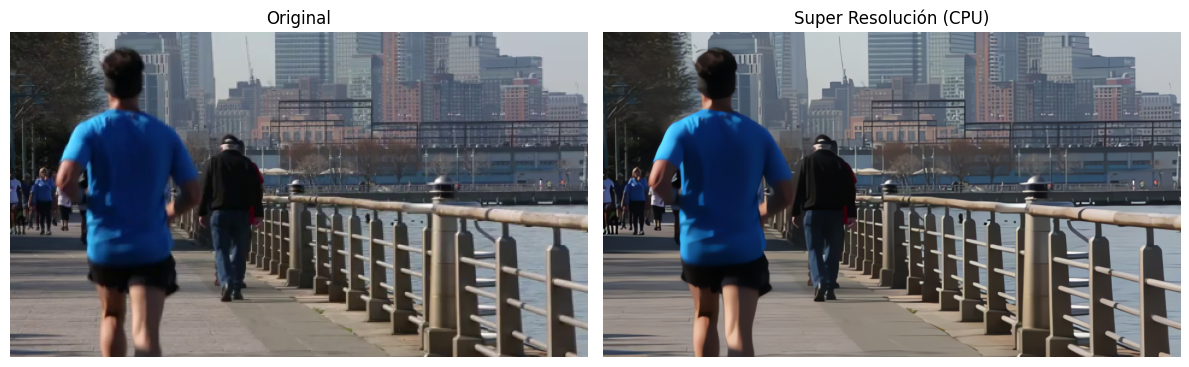

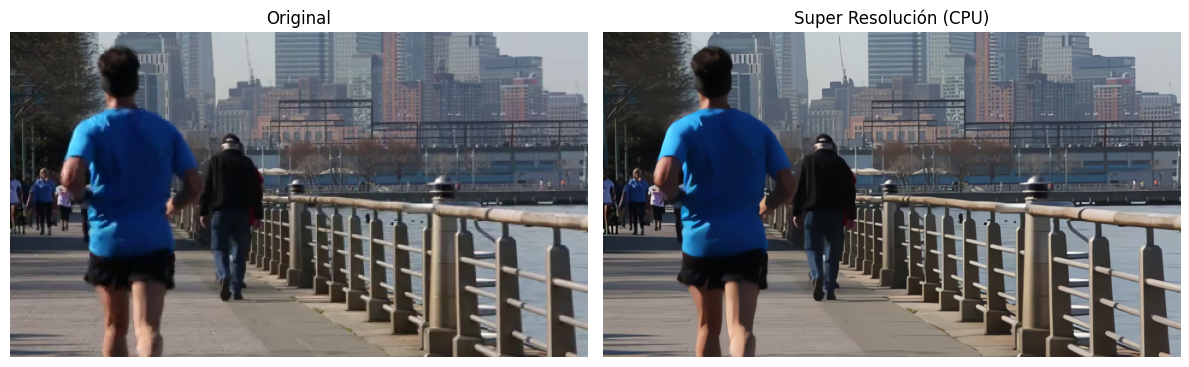

In [13]:
import torch
import cv2
import time
import psutil
import uuid
from realesrgan import RealESRGANer
from realesrgan.archs.srvgg_arch import SRVGGNetCompact
import matplotlib.pyplot as plt

# ===============================
# 1. IDENTIFICACIÓN DEL EQUIPO
# ===============================
mac_address = ':'.join(
    ['{:02x}'.format((uuid.getnode() >> ele) & 0xff) for ele in range(0, 8*6, 8)][::-1]
)

print("==========================================")
print(f"MAC Address del Equipo: {mac_address}")
print(f"CUDA Disponible: {torch.cuda.is_available()}")
print("==========================================\n")

# ===============================
# 2. CONFIGURACIÓN DEL DISPOSITIVO
# ===============================
device_name = "cpu"  # o "cpu"
if device_name == "cuda" and not torch.cuda.is_available():
    raise RuntimeError("CUDA no disponible en este equipo.")

# ===============================
# 3. CONFIGURACIÓN DEL MODELO SR
# ===============================
model_sr = SRVGGNetCompact(
    num_in_ch=3,
    num_out_ch=3,
    num_feat=64,
    num_conv=16,
    upscale=4,
    act_type='prelu'
)

weights_url = (
    "https://github.com/xinntao/Real-ESRGAN/releases/download/"
    "v0.2.5.0/realesr-animevideov3.pth"
)

upsampler = RealESRGANer(
    scale=4,
    model_path=weights_url,
    model=model_sr,
    tile=400,
    half=True if device_name == "cuda" else False,
    device=torch.device(device_name)
)

# ===============================
# 4. CARGAR VIDEO
# ===============================
video_path = "video.mp4"  # Video fijo
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise RuntimeError("No se pudo abrir el video.")

frame_count = 0
start_time = time.time()
muestras_sr = []  # Para mostrar evidencia final

# ===============================
# 5. PROCESAMIENTO (solo unos frames para evidencia)
# ===============================
num_frames_test = 5  # Solo procesamos 5 frames para mostrar evidencia

while cap.isOpened() and frame_count < num_frames_test:
    ret, frame = cap.read()
    if not ret:
        break

    # Reducir resolución para acelerar procesamiento
    frame_small = cv2.resize(frame, (480, 270))

    # Aplicar Super Resolución
    output, _ = upsampler.enhance(frame_small, outscale=2)

    # Guardar un par de frames para evidencia visual
    if frame_count == 0 or frame_count == 2:
        antes = cv2.cvtColor(frame_small, cv2.COLOR_BGR2RGB)
        despues = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
        muestras_sr.append((antes, despues))

    frame_count += 1

cap.release()

# ===============================
# 6. MÉTRICAS
# ===============================
total_time = time.time() - start_time
fps_sr = frame_count / total_time
ram_usage = psutil.virtual_memory().percent

print("\n" + "=" * 40)
print(f"RESULTADOS SUPER RESOLUTION ({device_name.upper()})")
print(f"FPS Promedio: {fps_sr:.2f}")
print(f"Uso de RAM del sistema: {ram_usage}%")
print("=" * 40)

# ===============================
# 7. VISUALIZACIÓN EN NOTEBOOK
# ===============================
for i, (antes, despues) in enumerate(muestras_sr):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].imshow(antes)
    axes[0].set_title("Original")
    axes[0].axis("off")

    axes[1].imshow(despues)
    axes[1].set_title(f"Super Resolución ({device_name.upper()})")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


**Evidencia de uso**

In [11]:
import torch
import cv2
import time
import psutil
import uuid
from realesrgan import RealESRGANer
from realesrgan.archs.srvgg_arch import SRVGGNetCompact

# 1. IDENTIFICACIÓN REQUERIDA POR LA GUÍA
# Obtener Mac Address única
mac_address = ':'.join(['{:02x}'.format((uuid.getnode() >> ele) & 0xff) for ele in range(0,8*6,8)][::-1])

print("==========================================")
print(f"DATOS DEL ESTUDIANTE / EQUIPO")
print(f"MAC ADDRESS: {mac_address}") #
print(f"CUDA DISPONIBLE: {torch.cuda.is_available()}") #
print("==========================================\n")

# 2. CONFIGURACIÓN DEL MODELO (SUPER RESOLUCIÓN)
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
model_sr = SRVGGNetCompact(num_in_ch=3, num_out_ch=3, num_feat=64, num_conv=16, upscale=4, act_type='prelu')
weights_url = 'https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.5.0/realesr-animevideov3.pth'

upsampler = RealESRGANer(
    scale=4,
    model_path=weights_url,
    model=model_sr,
    tile=400,
    half=True if device_name == 'cuda' else False,
    device=torch.device(device_name)
)

# 3. EJECUCIÓN Y CÁLCULO DE FPS
cap = cv2.VideoCapture("video.mp4")
frames_procesados = 0
start_time = time.time()

while cap.isOpened() and frames_procesados < 10:
    ret, frame = cap.read()
    if not ret: break

    # Aplicar Super Resolución
    frame_small = cv2.resize(frame, (640, 360))
    output, _ = upsampler.enhance(frame_small, outscale=2)
    frames_procesados += 1

# 4. REPORTE TÉCNICO COMPLETO PARA EL VIDEO
total_time = time.time() - start_time
fps_final = frames_procesados / total_time
ram_uso = psutil.virtual_memory().percent

print(">>> RESULTADOS DE RENDIMIENTO <<<")
print(f"FPS PROMEDIO ({device_name.upper()}): {fps_final:.2f}") #
print(f"USO DE RAM DEL SISTEMA: {ram_uso}%") #
print("-" * 40)

# MOSTRAR NVIDIA-SMI COMPLETO
if device_name == 'cuda':
    print("ESTADO DE LA GPU (nvidia-smi):")
    !nvidia-smi
else:
    print("No se puede mostrar nvidia-smi porque se está usando la CPU.")

cap.release()

DATOS DEL ESTUDIANTE / EQUIPO
MAC ADDRESS: 08:92:04:e5:98:36
CUDA DISPONIBLE: True

	Tile 1/2
	Tile 2/2
	Tile 1/2
	Tile 2/2
	Tile 1/2
	Tile 2/2
	Tile 1/2
	Tile 2/2
	Tile 1/2
	Tile 2/2
	Tile 1/2
	Tile 2/2
	Tile 1/2
	Tile 2/2
	Tile 1/2
	Tile 2/2
	Tile 1/2
	Tile 2/2
	Tile 1/2
	Tile 2/2
>>> RESULTADOS DE RENDIMIENTO <<<
FPS PROMEDIO (CUDA): 10.29
USO DE RAM DEL SISTEMA: 25.1%
----------------------------------------
ESTADO DE LA GPU (nvidia-smi):
Fri Jan  9 12:46:25 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                  

In [10]:
!!nvidia-smi

['Fri Jan  9 12:46:13 2026       ',
 '+-----------------------------------------------------------------------------------------+',
 '| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |',
 '+-----------------------------------------+------------------------+----------------------+',
 '| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |',
 '| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |',
 '|                                         |                        |               MIG M. |',
 '|=========================================+========================+======================|',
 '|   0  NVIDIA GeForce RTX 3070        On  |   00000000:01:00.0  On |                  N/A |',
 '| 30%   48C    P2             50W /  220W |    1667MiB /   8192MiB |      8%      Default |',
 '|                                         |                        |                  N/A |',
 '+-

# **CONCLUSIONES**

En esta fase se evaluó el impacto del backend de ejecución (CPU vs GPU) sobre el rendimiento de dos cargas computacionales representativas en visión por computador: detección/segmentación de personas mediante YOLOv11 y super resolución de video utilizando una red neuronal profunda basada en Real-ESRGAN. En ambos casos se mantuvo constante el pipeline de procesamiento, variando únicamente el dispositivo de ejecución.

Los resultados obtenidos muestran que la ejecución sobre GPU con CUDA permite incrementar de forma significativa la tasa de procesamiento (FPS) respecto a la CPU, siendo esta diferencia especialmente marcada en la tarea de super resolución, debido a su mayor complejidad computacional y al uso intensivo de operaciones convolucionales. En contraste, la ejecución en CPU presenta limitaciones claras para aplicaciones en tiempo real, incluso al reducir la resolución de entrada.

El monitoreo de recursos mediante nvidia-smi y las métricas de uso de memoria evidencian que la GPU no solo acelera la inferencia, sino que permite una utilización más eficiente del hardware para este tipo de tareas, justificando su uso en escenarios de procesamiento de video continuo. En conjunto, los experimentos confirman que la aceleración por GPU es un factor determinante para lograr un desempeño compatible con aplicaciones prácticas de visión por computador basadas en Deep Learning.